In [1]:
import torch,torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from model import Generator, iterate_minibatches, compute_loss, train

In [2]:
OCTAVE_NUM = 4
NOTE_NUM = 12
TIME_SCALE = 3

class LSTM_discriminator(nn.Module):
    def __init__(self,hidden_size = 1000):
        super(self.__class__, self).__init__()
        self.hidden_size = hidden_size
        self.note_lstm = nn.LSTM(input_size = OCTAVE_NUM*3,hidden_size = hidden_size)
        self.time_lstm = nn.LSTM(input_size = hidden_size,hidden_size = hidden_size)
        self.dense = nn.Linear(hidden_size,1)

    def forward(self,data):
        # data.size() =  (batch_size, TIME_SCALE, NOTE_NUM*OCTAVE_NUM, 3)
        # octave_data.size() =  (batch_size, TIME_SCALE, NOTE_NUM,OCTAVE_NUM*3)
        batch_size,_,_,_ = data.size()
        octave_data = data.view(batch_size,TIME_SCALE,NOTE_NUM,OCTAVE_NUM,3)\
                          .view(batch_size,TIME_SCALE,NOTE_NUM,OCTAVE_NUM*3)
            
        # note_lstm_input.size() = (NOTE_NUM, batch_size*TIME_SCALE,OCTAVE_NUM*3)
        note_lstm_input = octave_data.view(batch_size*TIME_SCALE,NOTE_NUM,OCTAVE_NUM*3)\
                                     .transpose(0,1)
        # note_lstm_output.size() = (NOTE_NUM,batch_size*TIME_SCALE,hidden_size)
        note_lstm_output, _ = self.note_lstm(note_lstm_input)
        # time_lstm_input.size() = (TIME_SCALE,batch_size,hidden_size)
        time_lstm_input = note_lstm_output[-1].view(batch_size,TIME_SCALE,self.hidden_size)\
                                          .transpose(0,1)\
        # time_lstm_output.size() = (TIME_SCALE,batch_size,1000)
        time_lstm_output, _  = self.time_lstm(time_lstm_input)
        # dense_input.size() = (batch_size,1000)
        dense_input = time_lstm_output[-1]
        # dense_output.size() = (batch_size,1)
        dense_output = self.dense(dense_input)
        probs = F.sigmoid(dense_output)
        return probs
        
        
        

In [3]:
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
discriminator = LSTM_discriminator(hidden_size=10).to(device)
np_data = np.random.randn(10,TIME_SCALE,NOTE_NUM*OCTAVE_NUM,3)
data = torch.FloatTensor(np_data).to(device)
discriminator(data)

tensor([[ 0.5125],
        [ 0.5093],
        [ 0.5150],
        [ 0.5123],
        [ 0.5143],
        [ 0.5119],
        [ 0.5106],
        [ 0.5122],
        [ 0.5161],
        [ 0.5136]], device='cuda:6')

In [4]:
class LSTM_baseline(nn.Module):
    def __init__(self,hidden_size = 1000):
        super(self.__class__, self).__init__()
        self.hidden_size = hidden_size
        self.note_lstm = nn.LSTM(input_size = OCTAVE_NUM*3,hidden_size = hidden_size)
        self.time_lstm = nn.LSTM(input_size = hidden_size,hidden_size = hidden_size)
        self.dense = nn.Linear(hidden_size,1)

    def forward(self,data):
        # data.size() =  (batch_size, TIME_SCALE, NOTE_NUM*OCTAVE_NUM, 3)
        # octave_data.size() =  (batch_size, TIME_SCALE, NOTE_NUM,OCTAVE_NUM*3)
        batch_size,_,_,_ = data.size()
        octave_data = data.view(batch_size,TIME_SCALE,NOTE_NUM,OCTAVE_NUM,3)\
                          .view(batch_size,TIME_SCALE,NOTE_NUM,OCTAVE_NUM*3)
            
        # note_lstm_input.size() = (NOTE_NUM, batch_size*TIME_SCALE,OCTAVE_NUM*3)
        note_lstm_input = octave_data.view(batch_size*TIME_SCALE,NOTE_NUM,OCTAVE_NUM*3)\
                                     .transpose(0,1)
        # note_lstm_output.size() = (NOTE_NUM,batch_size*TIME_SCALE,hidden_size)
        note_lstm_output, _ = self.note_lstm(note_lstm_input)
        # time_lstm_input.size() = (TIME_SCALE,batch_size,hidden_size)
        time_lstm_input = note_lstm_output[-1].view(batch_size,TIME_SCALE,self.hidden_size)\
                                          .transpose(0,1)\
        # time_lstm_output.size() = (TIME_SCALE,batch_size,1000)
        time_lstm_output, _  = self.time_lstm(time_lstm_input)
        # dense_input.size() = (batch_size,1000)
        dense_input = time_lstm_output[-1]
        # dense_output.size() = (batch_size,1)
        dense_output = self.dense(dense_input)
        probs = F.sigmoid(dense_output)
        return probs

In [6]:
discriminator = LSTM_baseline(hidden_size=1000).to(device)
np_data = np.random.randn(10,TIME_SCALE,NOTE_NUM*OCTAVE_NUM,3)
data = torch.FloatTensor(np_data).to(device)
discriminator(data)

tensor([[ 0.5019],
        [ 0.5029],
        [ 0.5029],
        [ 0.5017],
        [ 0.5030],
        [ 0.5024],
        [ 0.5023],
        [ 0.5027],
        [ 0.5025],
        [ 0.5037]])

In [7]:
class BasicGenerator(nn.Module):
    def __init__(self,hidden_size = 1000):
        super(self.__class__, self).__init__()
        self.dense_in = nn.Linear(TIME_SCALE*NOTE_NUM*OCTAVE_NUM*3,hidden_size)
        self.dense_out = nn.Linear(hidden_size,TIME_SCALE*NOTE_NUM*OCTAVE_NUM*3)

    def forward(self,data):
        batch_size,_,_,_ = data.size()
        data = data.view(batch_size,-1)
        hid_data = self.dense_in(data)
        out_data = self.dense_out(hid_data)
        output = F.sigmoid(out_data.view(batch_size, TIME_SCALE, NOTE_NUM*OCTAVE_NUM, 3))
        return output
        

In [ ]:
class SequenceGenerator(nn.Module):
    def __init__(self,seq_len):
        super(self.__class__, self).__init__()
        self.dense_in = nn.Linear(TIME_SCALE*NOTE_NUM*OCTAVE_NUM*3,hidden_size)

    def forward(self,data):
        batch_size,_,_,_ = data.size()
        data = data.view(batch_size,-1)
        hid_data = self.dense_in(data)
        out_data = self.dense_out(hid_data)
        output = F.sigmoid(out_data.view(batch_size, TIME_SCALE, NOTE_NUM*OCTAVE_NUM, 3))
        return output

In [5]:
generator = Generator().to(device)
# generator()

/usr/local/lib/python3.5/dist-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [6]:
def g_loss(p_fake,eps = 1e-8):
    return -(p_fake+eps).log().mean()
def d_loss(p_fake, p_true,eps = 1e-8):
     return -((1-p_fake+eps).log().mean()-(p_true+eps).log().mean())


In [7]:
import torch.utils.data

def train_GAN(generator,discriminator,X_loader,Y_loader,num_epochs = 3,g_lr = 0.001, d_lr = 0.001):
    g_optimizer = torch.optim.Adam(generator.parameters(),     lr=g_lr, betas=(0.5, 0.999))
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=d_lr, betas=(0.5, 0.999))
    d_losses = []
    g_losses = []
    for epoch in range(num_epochs):
        for [x_batch,ch_batch],[y_batch] in zip(X_loader,Y_loader):
            x_batch = Variable(x_batch, requires_grad = True).to(device)
            ch_batch = Variable(ch_batch, requires_grad = True).to(device)
            y_batch = Variable(y_batch, requires_grad = True).to(device)
            # Optimize D
            data_gen = generator(x_batch,ch_batch)
            loss = d_loss(discriminator(data_gen), discriminator(y_batch))
            d_optimizer.zero_grad()
            loss.backward()
#             print(loss.grad)
            d_optimizer.step()
            d_losses.append(loss.data.cpu().numpy())

            # Optimize G
            data_gen = generator(x_batch,ch_batch)
            loss = g_loss(discriminator(data_gen))
            g_optimizer.zero_grad()
            loss.backward()
#             print(loss.grad)
            g_optimizer.step()
            g_losses.append(loss.data.cpu().numpy())
    return generator,discriminator,np.array(g_losses),np.array(d_losses)

In [32]:
N = 100
X_loader = torch.utils.data.DataLoader(\
            torch.utils.data.TensorDataset(\
            *(torch.randn(N,TIME_SCALE,NOTE_NUM*OCTAVE_NUM,3)+10,
            torch.randn(N,TIME_SCALE,NOTE_NUM*OCTAVE_NUM,3)+10)),\
            batch_size=10,shuffle=True)
Y_loader = torch.utils.data.DataLoader(\
            torch.utils.data.TensorDataset(\
            torch.randn(N,TIME_SCALE,NOTE_NUM*OCTAVE_NUM,3)),\
            batch_size=10,shuffle=True)

In [38]:
# device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
# generator = Generator().to(device)
# discriminator = LSTM_baseline(hidden_size=10).to(device)
generator,discriminator,g_losses,d_losses =\
                train_GAN(generator,discriminator,X_loader,Y_loader,num_epochs = 1, g_lr = 0.1, d_lr = 0)

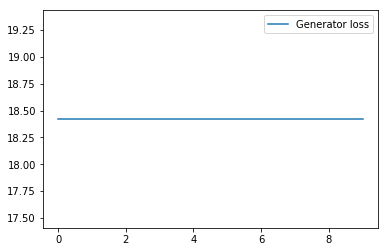

In [40]:
import matplotlib.pyplot as plt
plt.plot(g_losses,label = "Generator loss")
# plt.plot(d_losses,label = "Discriminator loss")
plt.legend()
plt.show()

In [37]:
g_losses

array([18.420671, 18.420677, 18.42068 , 18.42068 , 18.42068 , 18.42068 ,
       18.42068 , 18.420681, 18.420681, 18.420681], dtype=float32)

In [39]:
g_losses

array([18.420681, 18.420681, 18.420681, 18.420681, 18.420681, 18.420681,
       18.420681, 18.420681, 18.420681, 18.420681], dtype=float32)